Updated Training Dataset:
Total Training Images: 194
Defected Images: 97
Non-Defected Images: 97
Combined Training Images Shape: (194, 512, 640, 3)
Combined Training Labels Shape: (194,)
Training Labels Distribution: [97 97]


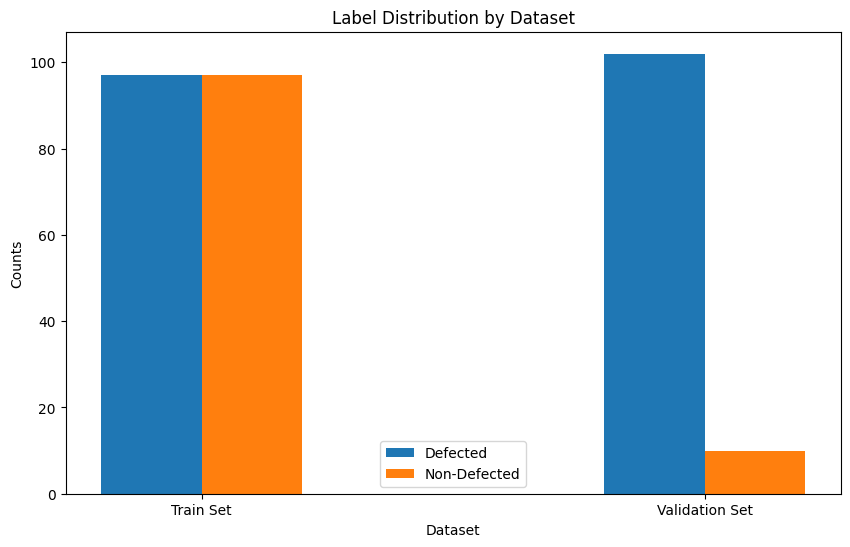

In [2]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from matplotlib import pyplot as plt

# 路径设置
train_image_dir = r'E:\CDUT\English\7 Term\Project\model\archive\dataset\images'
train_annotation_dir = r'E:\CDUT\English\7 Term\Project\model\archive\dataset\annotations'

val_image_dir = r'E:\CDUT\English\7 Term\Project\model\archive\dataset_2\images'
val_annotation_dir = r'E:\CDUT\English\7 Term\Project\model\archive\dataset_2\annotations'

additional_image_dir = r'E:\CDUT\English\7 Term\Project\model\archive\extra'
additional_val_image_dir = r'E:\CDUT\English\7 Term\Project\model\archive\extra_val'

IMG_HEIGHT = 512
IMG_WIDTH = 640
BATCH_SIZE = 16

def preprocess_to_grayscale(image_dir, target_size):
    processed_images = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(image_dir, filename)
            img = load_img(img_path, target_size=target_size).convert('L')
            img_array = img_to_array(img) / 255.0
            img_array = np.repeat(img_array, 3, axis=-1)
            processed_images.append(img_array)
    return np.array(processed_images)

def preprocess_additional_defected_images(image_dir, target_size):
    processed_images = []
    labels = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(image_dir, filename)
            img = load_img(img_path, target_size=target_size).convert('L')  # 转为灰度
            img_array = img_to_array(img) / 255.0  # 归一化
            img_array = np.repeat(img_array, 3, axis=-1)  # 转为 3 通道
            processed_images.append(img_array)
            labels.append(1)  # 缺陷图片标签为 1

    return np.array(processed_images), np.array(labels)

def load_dataset_with_corners(image_dir, annotation_dir):
    labels = []
    corners_list = []
    true_count = 0  # 计数 defected_module=true 的图片
    total_images = 0  # 总图片数

    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            total_images += 1
            annotation_path = os.path.join(annotation_dir, filename.replace('.jpg', '.json').replace('.png', '.json'))
            with open(annotation_path, 'r') as f:
                annotation = json.load(f)
                instance_data = annotation["instances"]

                image_corners = []
                image_labels = []
                for instance in instance_data:
                    corners = instance["corners"]
                    defected = instance["defected_module"]
                    if defected:
                        true_count += 1
                    image_corners.append([(corner['x'], corner['y']) for corner in corners])
                    image_labels.append(1 if defected else 0)

                corners_list.append(image_corners)
                labels.append(image_labels)

    return corners_list, labels, true_count, total_images

# 加载和预处理数据集
train_images_gray = preprocess_to_grayscale(train_image_dir, target_size=(IMG_HEIGHT, IMG_WIDTH))
train_corners, train_labels, train_true_count, train_total_images = load_dataset_with_corners(train_image_dir, train_annotation_dir)

val_images_gray = preprocess_to_grayscale(val_image_dir, target_size=(IMG_HEIGHT, IMG_WIDTH))
val_corners, val_labels, val_true_count, val_total_images = load_dataset_with_corners(val_image_dir, val_annotation_dir)

# 处理额外的缺陷图片
additional_images, additional_labels = preprocess_additional_defected_images(additional_image_dir, target_size=(IMG_HEIGHT, IMG_WIDTH))
additional_val_images, additional_val_labels = preprocess_additional_defected_images(additional_val_image_dir, target_size=(IMG_HEIGHT, IMG_WIDTH))

# 合并数据
train_images_combined = np.concatenate((train_images_gray, additional_images), axis=0)
train_labels_binary = np.array([1 if any(label) else 0 for label in train_labels])
train_labels_combined = np.concatenate((train_labels_binary, additional_labels), axis=0)

# 验证集标签处理
val_images_combined = np.concatenate((val_images_gray, additional_val_images), axis=0)
val_labels_binary = np.array([1 if any(label) else 0 for label in val_labels])
val_labels_combined = np.concatenate((val_labels_binary, additional_val_labels), axis=0)

# 更新训练集计数
num_defected = np.sum(train_labels_combined == 1)  # 缺陷图片数量
num_non_defected = np.sum(train_labels_combined == 0)  # 非缺陷图片数量

print(f"Updated Training Dataset:")
print(f"Total Training Images: {train_images_combined.shape[0]}")
print(f"Defected Images: {num_defected}")
print(f"Non-Defected Images: {num_non_defected}")

print(f"Combined Training Images Shape: {train_images_combined.shape}")
print(f"Combined Training Labels Shape: {train_labels_combined.shape}")
print(f"Training Labels Distribution: {np.bincount(train_labels_combined)}")

# 标签分布可视化
def plot_label_distribution(train_labels, val_labels):
    categories = ['Defected', 'Non-Defected']

    train_dist = [np.sum(train_labels == 1), np.sum(train_labels == 0)]
    val_dist = [np.sum(val_labels == 1), np.sum(val_labels == 0)]

    x = ['Train Set', 'Validation Set']
    defected = [train_dist[0], val_dist[0]]
    non_defected = [train_dist[1], val_dist[1]]

    x_pos = np.arange(len(x))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x_pos - width / 2, defected, width, label='Defected')
    ax.bar(x_pos + width / 2, non_defected, width, label='Non-Defected')

    ax.set_xlabel('Dataset')
    ax.set_ylabel('Counts')
    ax.set_title('Label Distribution by Dataset')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x)
    ax.legend()

    plt.show()

plot_label_distribution(train_labels_combined, val_labels_combined)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 14, 18, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 7,435,713
Non-trainable params: 14,629,472
_________________________________________________________________
Starting model training...
Epoch 1/100
13/13 [==============================] - 14s 591ms/step - loss:

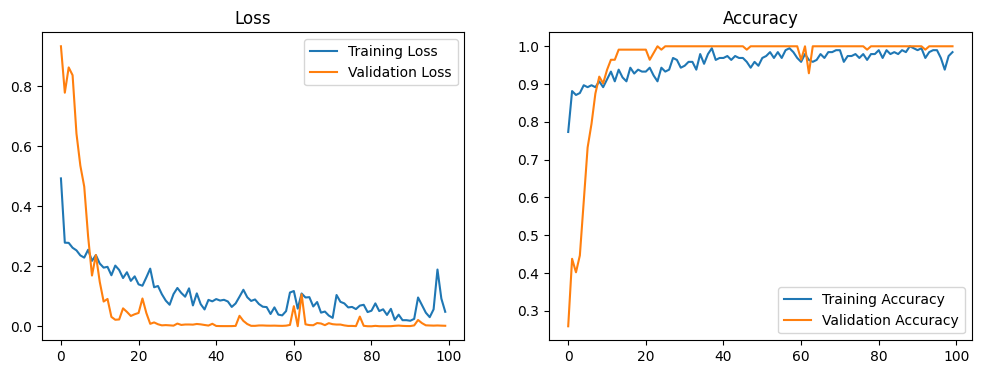

Predictions: [9.9935585e-01 1.2988144e-07 1.0441621e-03 2.4804180e-03 6.3224499e-05
 8.6868828e-04 1.6506197e-04 5.3879543e-05 1.6043395e-04 6.0484940e-03]
True Labels: [1 0 0 0 0 0 0 0 0 0]


In [3]:
# 模型构建
def build_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(train_images_combined)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_combined),
    y=train_labels_combined
)
class_weights = dict(enumerate(class_weights))

print("Starting model training...")
history = model.fit(
    datagen.flow(train_images_combined, train_labels_combined, batch_size=BATCH_SIZE),
    validation_data=(val_images_combined, val_labels_combined),
    epochs=100,
    class_weight=class_weights
)

val_loss, val_acc = model.evaluate(val_images_combined, val_labels_combined, batch_size=BATCH_SIZE)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

plot_training(history)

predictions = model.predict(val_images_combined)
print(f"Predictions: {predictions[:10].flatten()}")
print(f"True Labels: {val_labels_combined[:10]}")


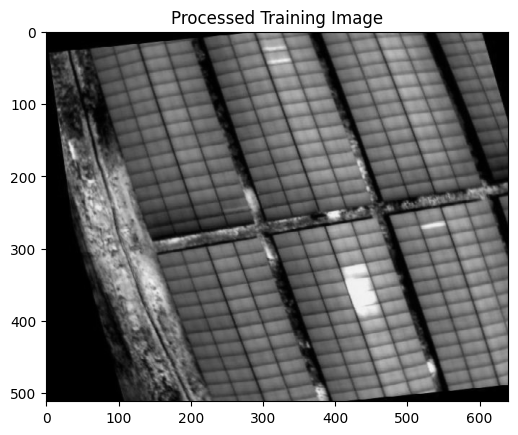

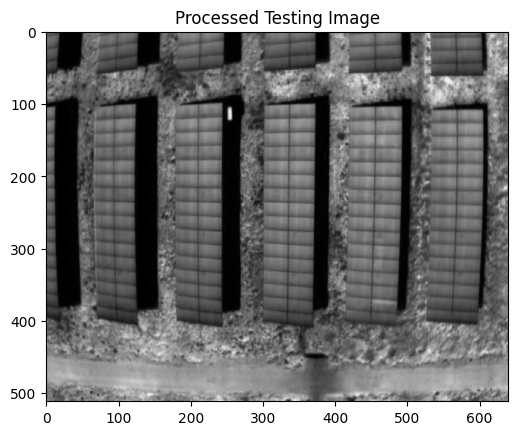

In [4]:
import matplotlib.pyplot as plt

plt.imshow(train_images_combined[120])
plt.title("Processed Training Image")
plt.show()

plt.imshow(val_images_combined[12])
plt.title("Processed Testing Image")
plt.show()

In [5]:
# 获取嵌套的 InceptionV3 模型
inception_v3 = model.get_layer("inception_v3")

# 打印 InceptionV3 内部所有层名称
for layer in inception_v3.layers:
    print(layer.name)

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

Confusion Matrix:
[[ 10   0]
 [  0 102]]
Sensitivity (Recall): 1.0000
Specificity: 1.0000


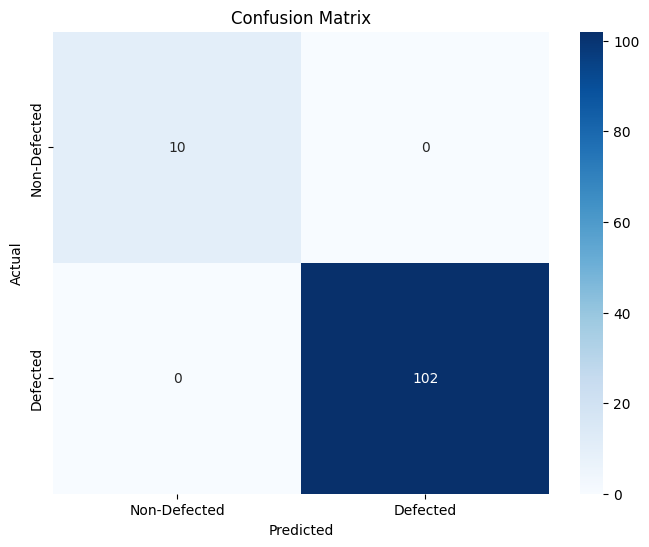

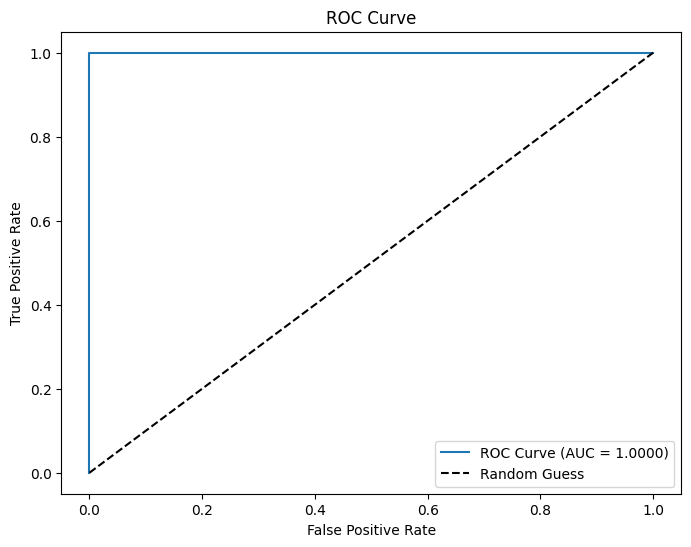

Precision-Recall AUC: 1.0000
F1 Score: 1.0000


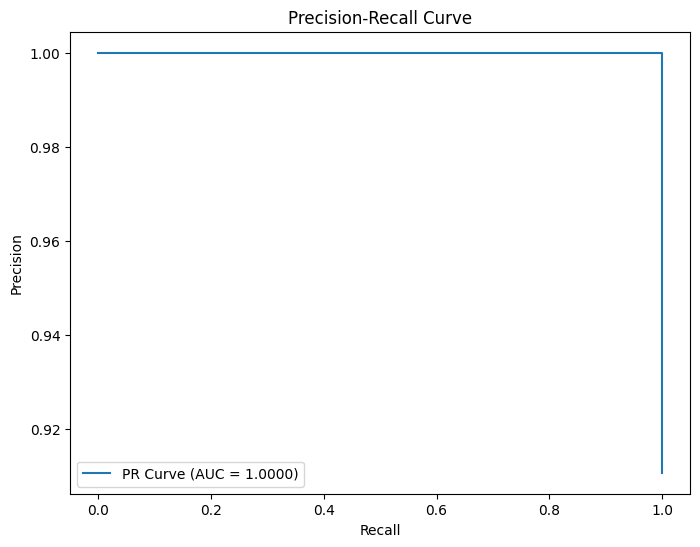

Classification Report:
               precision    recall  f1-score   support

Non-Defected       1.00      1.00      1.00        10
    Defected       1.00      1.00      1.00       102

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112



In [6]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
import seaborn as sns

# 预测标签
y_pred = model.predict(val_images_combined)
y_pred_binary = (y_pred.flatten() > 0.5).astype(int)

# 混淆矩阵
cm = confusion_matrix(val_labels_combined, y_pred_binary)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Confusion Matrix:\n{cm}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Defected", "Defected"], yticklabels=["Non-Defected", "Defected"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC 曲线和 AUC
fpr, tpr, _ = roc_curve(val_labels_combined, y_pred.flatten())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall 曲线和 F1 分数
precision, recall, _ = precision_recall_curve(val_labels_combined, y_pred.flatten())
pr_auc = auc(recall, precision)
f1 = f1_score(val_labels_combined, y_pred_binary)

print(f"Precision-Recall AUC: {pr_auc:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# 分类报告
report = classification_report(val_labels_combined, y_pred_binary, target_names=["Non-Defected", "Defected"])
print("Classification Report:\n", report)


Predictions shape: (1, 14, 18, 2048)
Selected class_idx: 2008
Image shape: (512, 640, 3)
Heatmap shape: (512, 640, 3)


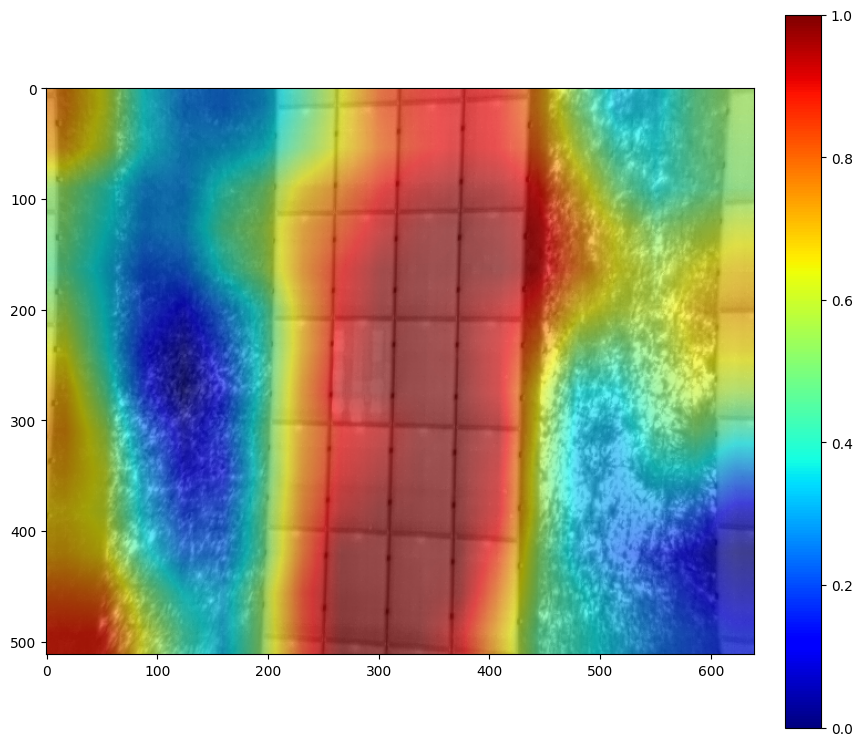

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
import cv2

def generate_grad_cam(model, img_array, target_layer_name, class_idx=None):
    # 获取目标层
    target_layer = model.get_layer(target_layer_name)
    grad_model = Model(inputs=model.input, outputs=[target_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        # 检查 predictions 的形状
        print(f"Predictions shape: {predictions.shape}")

        # 如果 class_idx 为 None，选择最大预测值对应的索引
        if class_idx is None:
            class_idx = tf.argmax(predictions, axis=-1)  # 获取最大预测值的类别索引
            class_idx = tf.reduce_max(class_idx)  # 确保 class_idx 是标量
            print(f"Selected class_idx: {class_idx.numpy()}")

        # 确保 class_idx 是标量
        class_idx = tf.cast(class_idx, tf.int32)

        # 计算 loss
        loss = tf.reduce_mean(predictions[..., class_idx])  # 确保 predictions 是 [batch_size, height, width, num_classes] 格式

    # 计算梯度
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 生成热力图
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_grad_cam(img_path, heatmap, output_size=(640, 512), alpha=0.6):
    img = load_img(img_path)
    img = img.resize(output_size)
    img = img_to_array(img).astype("uint8")
    
    # 确保热力图的大小和通道数与输入图像匹配
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (output_size[0], output_size[1]))  # 调整热力图大小
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # 确保输入图像和热力图的通道数匹配
    if img.shape[-1] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # 检查图像和热力图的大小和通道数
    print(f"Image shape: {img.shape}")
    print(f"Heatmap shape: {heatmap.shape}")
    
    # 调整图像和热力图的大小和通道数
    if img.shape[:2] != heatmap.shape[:2]:
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    if img.shape[-1] != heatmap.shape[-1]:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), orientation='vertical', fraction=0.046, pad=0.04)
    plt.show()
    
# 预处理输入图像
def preprocess_image(img_path, target_size=(512, 640)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


# 模型加载
model = tf.keras.models.load_model('./solar_cell_model_with_inceptionv3.h5')  # 替换为你的模型路径

# 提取嵌套的 InceptionV3 模型
inception_model = model.get_layer("inception_v3")

# 目标层名称设置为 InceptionV3 的最后一个卷积层
target_layer_name = "mixed10"

# 测试图像路径
img_path = r'E:\CDUT\English\7 Term\Project\model\archive\dataset\images\041R.jpg'  # 替换为你的测试图像路径
img_array = preprocess_image(img_path, target_size=(512, 640))

# 生成 Grad-CAM
heatmap = generate_grad_cam(inception_model, img_array, target_layer_name)

# 显示结果
display_grad_cam(img_path, heatmap)


In [8]:
from numba import cuda

cuda.select_device(0)
cuda.close()